# Compare reservoir models
***

**Author:** *Chus Casado Rodríguez*<br>
**Date:** *31-07-2024*<br>

**Introduction:**<br>

This notebooks compares the results of simulating 97 reservoirs from the ResOpsUS. These reservoirs were selected because the include observed data for the three variables inflow, storage and outflow for at least 8 consecutive years.

**Ideas:**<br>

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path
# import geopandas as gpd
import yaml
import pickle

from lisfloodreservoirs import Config, read_attributes, read_timeseries
from lisfloodreservoirs.utils.plots import maps_performance, boxplot_parameters
from lisfloodreservoirs.utils.metrics import KGEmod, ECDF, PDE
from lisfloodreservoirs.utils.utils import CDF, get_normal_value, return_period
from lisfloodreservoirs.calibration import read_results

## Configuration

In [2]:
cfg = Config('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsUS/results/mhm/config_storage.yml')

PATH_RESULTS = cfg.PATH_DEF.parent.parent

models = ['linear', 'lisflood', 'hanazaki', 'mhm', 'starfit']

runs = {
    'default': 'default',
    'SCEUA-S': 'calibration/univariate/storage',
    'SCEUA-Q': 'calibration/univariate/outflow',
    'SCEUA-QS': 'calibration/bivariate'
}

## Data

### Attributes

In [3]:
# list of reservoirs to be trained
reservoirs = pd.read_csv(cfg.RESERVOIRS_FILE, header=None).squeeze().tolist()

# import all tables of attributes
attributes = read_attributes(cfg.PATH_DATA / 'attributes', reservoirs)

# invert the one-hot encoder of main reservoir use
col_use = attributes.columns[attributes.columns.str.contains('MAIN_')]
col_use = [col for col in col_use if 'BASIN' not in col]
main_use = attributes[col_use].idxmax(axis=1)
attributes['MAIN_USE'] = main_use.replace({col: col.split('_')[-1] for col in col_use})
attributes.drop(col_use, axis=1, inplace=True)

#### Time series

In [14]:
# training periods
with open(cfg.PERIODS_FILE, 'rb') as file:
    periods = pickle.load(file)
periods = {str(key): value for key, value in periods.items()}

# read time series
timeseries = read_timeseries(cfg.PATH_DATA / 'time_series' / 'csv',
                                 attributes.index,
                                 periods)

In [5]:
# compute 100-year return period of the inflow
Q100 = [return_period(ts.inflow, T=100) for grand_id, ts in timeseries.items()]
Q100 = xr.DataArray(data=Q100, coords=[list(timeseries)], dims=['ID'])

## Load results

In [7]:
parameters = {}
performance = []
for model in tqdm(models, desc='reservoir model'):

    pars_model = []
    perf_model = []
    for run, subpath  in runs.items():

        path = PATH_RESULTS / model / subpath

        # load parameters
        try:
            pars_run = []
            for file in path.glob('*_parameters.yml'):
                grand_id = int(file.stem.split('_')[0])
                if grand_id not in reservoirs:
                    continue
                with open(file, 'r') as f:
                     dct = yaml.load(f, Loader=yaml.FullLoader)
                ds = xr.Dataset({key: xr.DataArray(value) for key, value in dct.items()})
                ds = ds.assign_coords(ID=[grand_id], run=[run])
                pars_run.append(ds)
            pars_model.append(xr.concat(pars_run, dim='ID'))
        except Exception as e:
            print(f'Error while reading parameters from model {model} and run {run}:\n{e}')                                
        
        # load performance
        try:
            perf_run = []
            for file in (path).glob('*_performance.csv'):
                grand_id = int(file.stem.split('_')[0])
                if grand_id not in reservoirs:
                    continue
                ds = xr.Dataset.from_dataframe(pd.read_csv(file, index_col='metric'))
                ds = ds.assign_coords(model=[model], run=[run], ID=[grand_id])
                perf_run.append(ds)
            perf_model.append(xr.concat(perf_run, dim='ID'))
        except Exception as e:
            print(f'Error while reading performance from model {model} and run {run}:\n{e}')  
    
    try:
        parameters[model] = xr.concat(pars_model, dim='run')
    except:
        pass
    try:
        performance.append(xr.concat(perf_model, dim='run'))
    except:
        pass

performance = xr.concat(performance, dim='model')

reservoir model:   0%|          | 0/5 [00:00<?, ?it/s]

Error while reading parameters from model starfit and run default:
must supply at least one object to concatenate
Error while reading performance from model starfit and run default:
must supply at least one object to concatenate
Error while reading parameters from model starfit and run SCEUA-S:
must supply at least one object to concatenate
Error while reading performance from model starfit and run SCEUA-S:
must supply at least one object to concatenate
Error while reading parameters from model starfit and run SCEUA-Q:
must supply at least one object to concatenate
Error while reading performance from model starfit and run SCEUA-Q:
must supply at least one object to concatenate
Error while reading parameters from model starfit and run SCEUA-QS:
must supply at least one object to concatenate


## Analysis

### Performance

#### Compare simulations

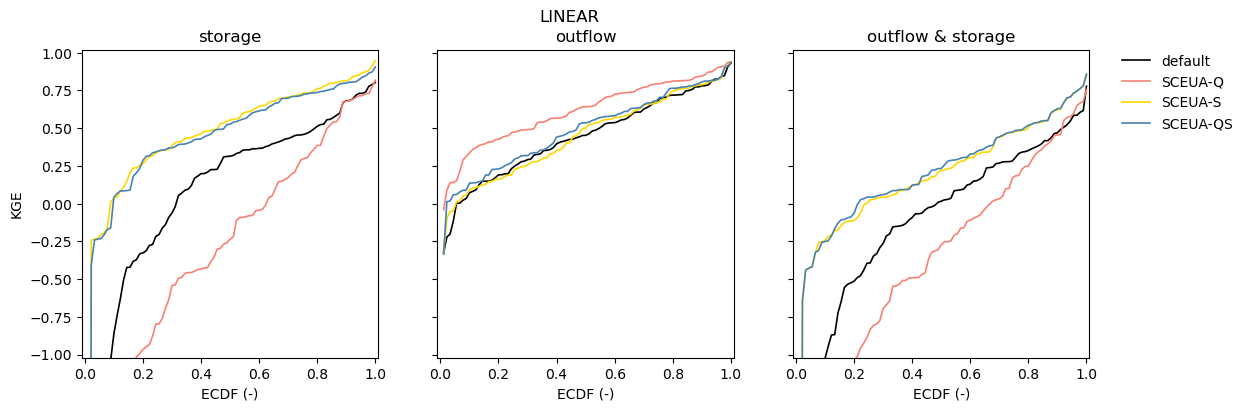

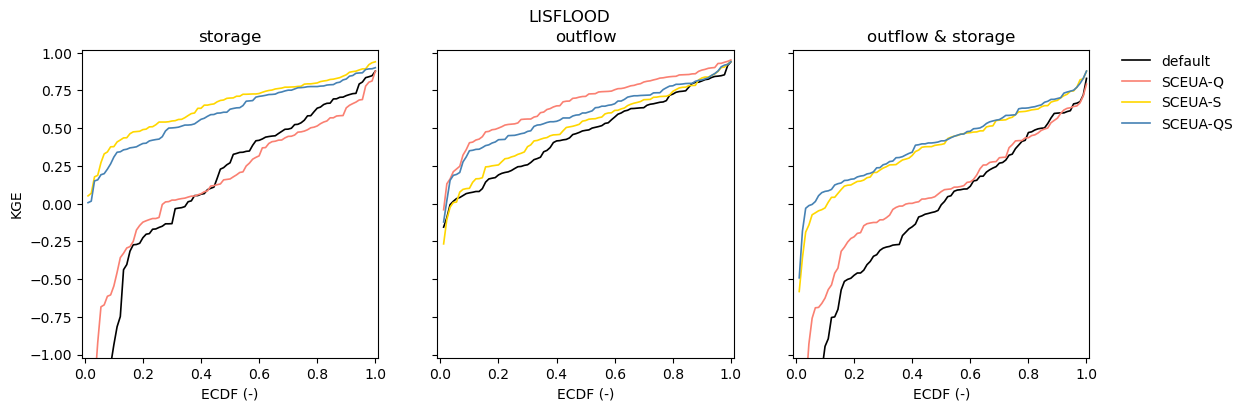

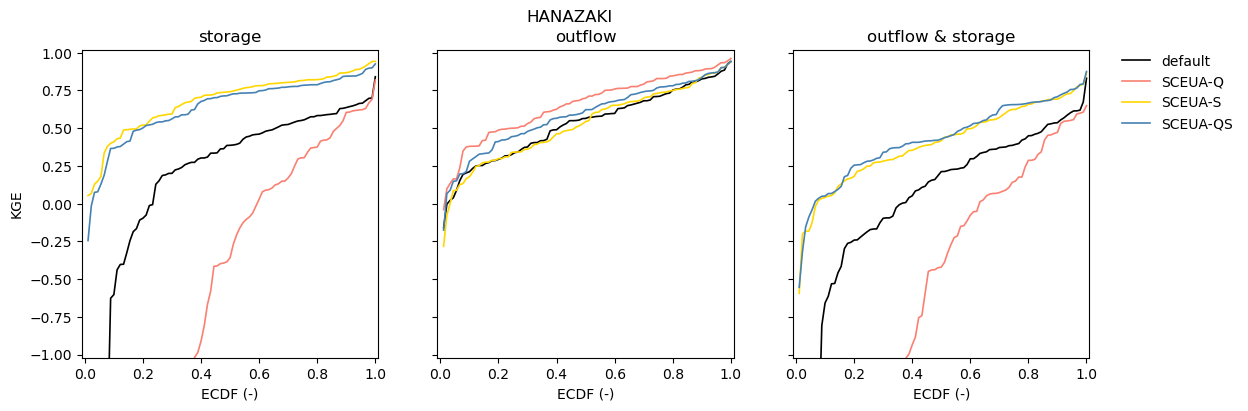

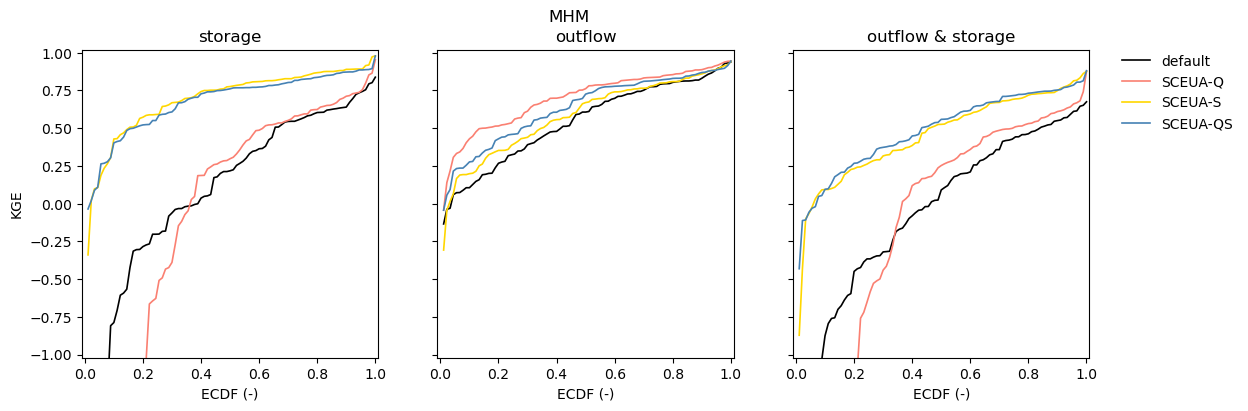

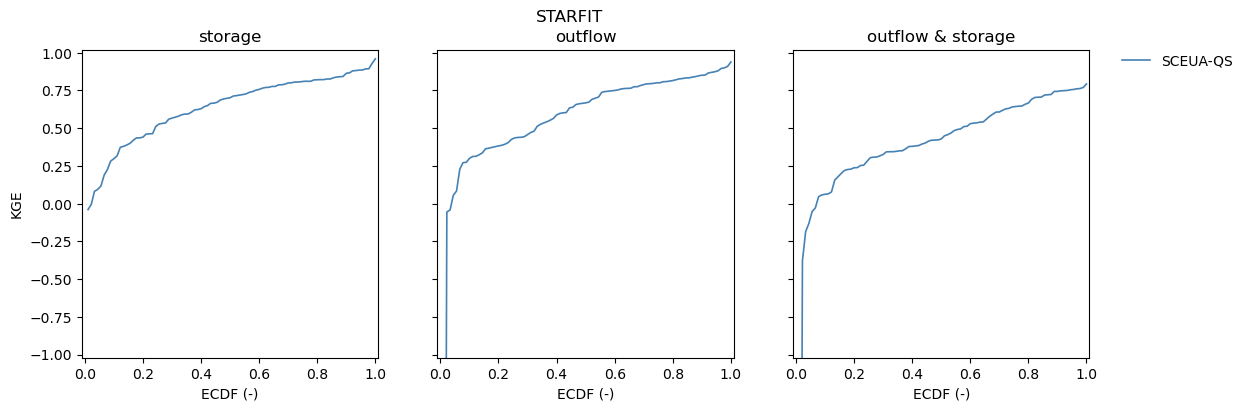

In [20]:
run_color = {
    'default': 'k',
    'SCEUA-Q': 'salmon',
    'SCEUA-S': 'gold',#'khaki',
    'SCEUA-QS': 'steelblue'
}

metric = 'KGE'

for model in performance.model.data:
    
    fig, axes = plt.subplots(ncols=3, figsize=(13, 4), sharex=True, sharey=True)

    perf = performance.sel(model=model, metric=metric)
    perf = perf.dropna('run', how='all')
    
    for ax, var in zip(axes, ['storage', 'outflow']):
        da = perf[var]
        # for run in da.run.data:
        for run, c in run_color.items():
            if run not in perf.run.data:
                continue
            ecdf = ECDF(da.sel(run=run).to_pandas(), plot=False)
            ax.plot(ecdf.index, ecdf.values, c=c, lw=1.2, label=run)
        ax.set(#xlim=(-1.02, 1.02),
               #ylim=(-.01, 1.01),
               xlabel='ECDF (-)',
               title=var)
        if ax == axes[0]:
            ax.set_ylabel(metric)

    ax = axes[2]
    KGE_bivar = 1 - ((1 - perf['storage'])**2 + (1 - perf['outflow'])**2)**.5
    # for run in KGE_bivar.run.data:
    for run, c in run_color.items():
        if run not in perf.run.data:
            continue
        ecdf = ECDF(KGE_bivar.sel(run=run).to_pandas(), plot=False)
        ax.plot(ecdf.index, ecdf.values, c=c, lw=1.2, label=run)
    ax.set(ylim=(-1.02, 1.02),
           xlim=(-.01, 1.01),
           xlabel='ECDF (-)',
           title='outflow & storage')

    fig.legend(*ax.get_legend_handles_labels(), frameon=False, bbox_to_anchor=[.92, .6, .1, .3]);
    fig.suptitle(model.upper());

    plt.savefig(PATH_RESULTS / model / f'ecdf_KGE.jpg', dpi=300, bbox_inches='tight');

In [8]:
performance.sel(metric='KGE', model='linear').median('ID').to_pandas()

,metric,inflow,storage,outflow,model
run,,,,,
default,KGE,1.0,0.3175,0.4575,linear
SCEUA-S,KGE,1.0,0.5400,0.5445,linear
SCEUA-Q,KGE,1.0,-0.3710,0.6420,linear
SCEUA-QS,KGE,1.0,0.4425,0.5550,linear


In [9]:
performance.sel(metric='KGE', model='lisflood').median('ID').to_pandas()

,metric,inflow,storage,outflow,model
run,,,,,
default,KGE,1.0,0.229,0.506,lisflood
SCEUA-S,KGE,1.0,0.676,0.559,lisflood
SCEUA-Q,KGE,1.0,0.192,0.732,lisflood
SCEUA-QS,KGE,1.0,0.657,0.629,lisflood


In [10]:
performance.sel(metric='KGE', model='hanazaki').median('ID').to_pandas()

,metric,inflow,storage,outflow,model
run,,,,,
default,KGE,1.0,0.363,0.577,hanazaki
SCEUA-S,KGE,1.0,0.735,0.607,hanazaki
SCEUA-Q,KGE,1.0,-0.262,0.722,hanazaki
SCEUA-QS,KGE,1.0,0.704,0.636,hanazaki


In [11]:
performance.sel(metric='KGE', model='mhm').median('ID').to_pandas()

,metric,inflow,storage,outflow,model
run,,,,,
default,KGE,1.0,0.2215,0.609,mhm
SCEUA-S,KGE,1.0,0.7580,0.687,mhm
SCEUA-Q,KGE,1.0,0.2890,0.780,mhm
SCEUA-QS,KGE,1.0,0.7370,0.750,mhm


#### Compare models

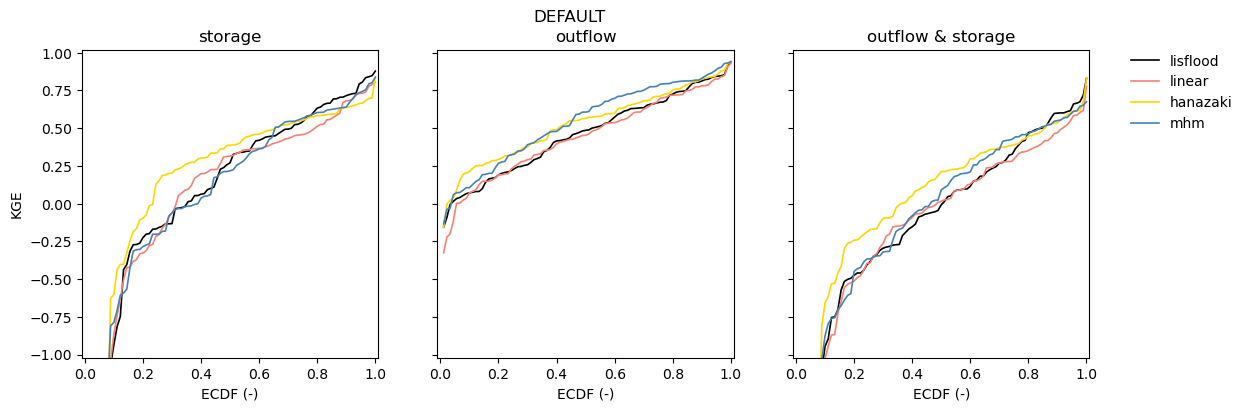

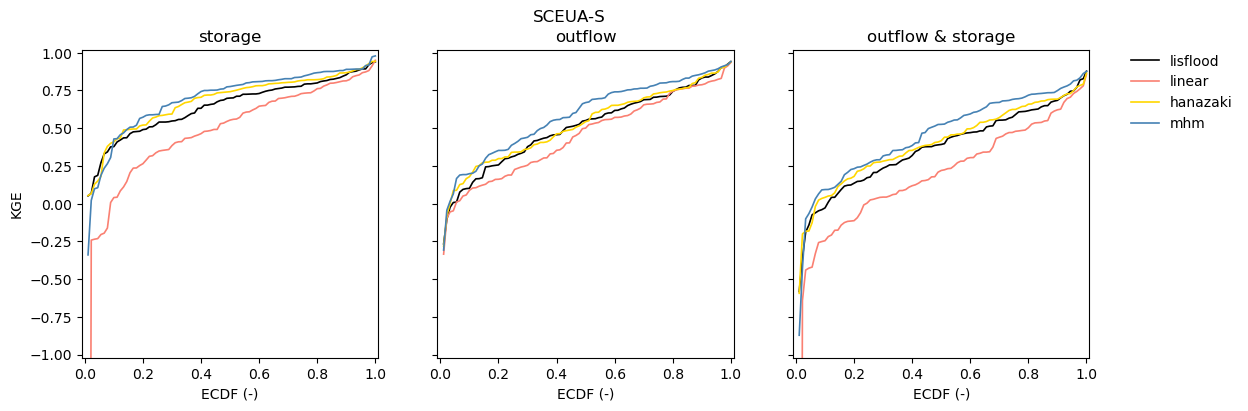

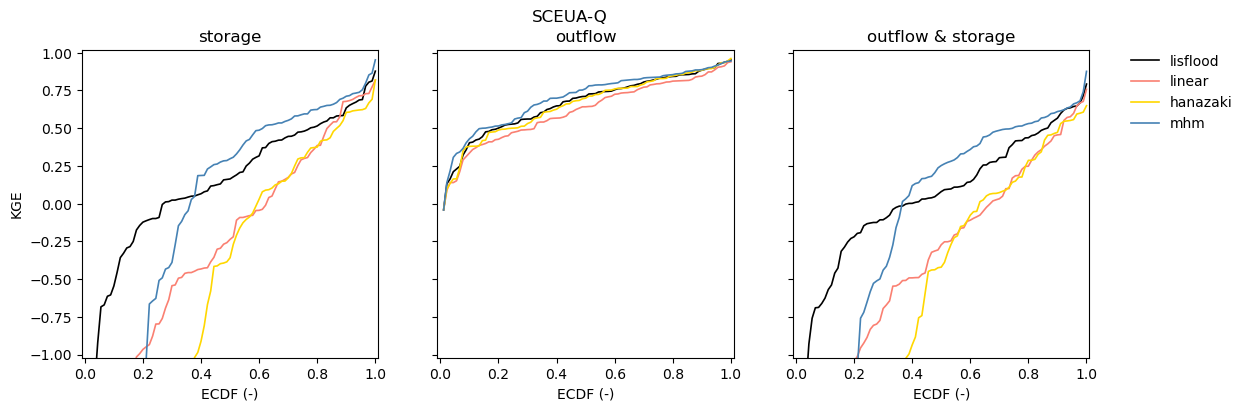

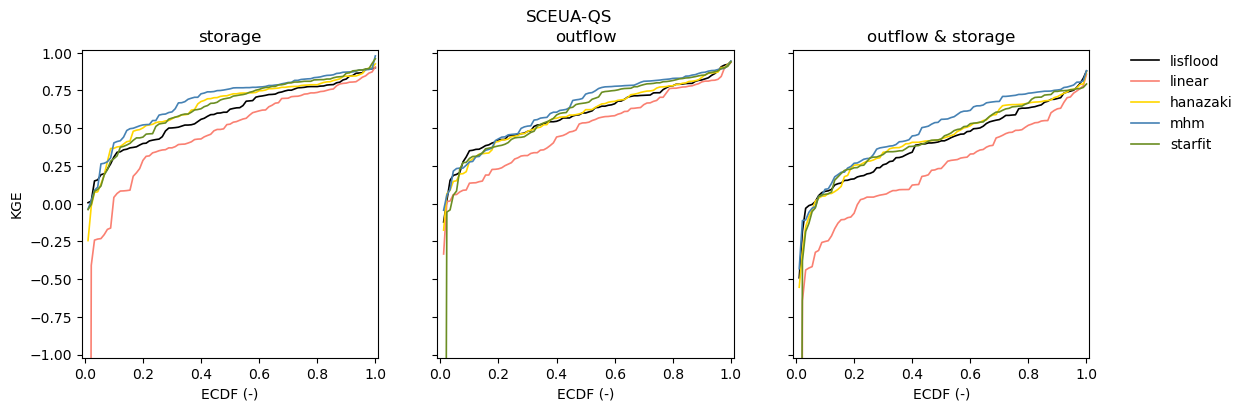

In [21]:
model_color = {
    'lisflood': 'k',
    'linear': 'salmon',
    'hanazaki': 'gold',#'khaki',
    'mhm': 'steelblue',
    'starfit': 'olivedrab'
}

metric = 'KGE'

for run in runs: #performance.run.data:
    
    fig, axes = plt.subplots(ncols=3, figsize=(13, 4), sharex=True, sharey=True)

    perf = performance.sel(run=run, metric=metric)
    perf = perf.dropna('model', how='all')
    
    for ax, var in zip(axes, ['storage', 'outflow']):
        da = perf[var]
        for model, c in model_color.items():
            if model not in perf.model.data:
                continue
            ecdf = ECDF(da.sel(model=model).to_pandas(), plot=False)
            ax.plot(ecdf.index, ecdf.values, c=c, lw=1.2, label=model)
        ax.set(xlabel='ECDF (-)',
               title=var)
        if ax == axes[0]:
            ax.set_ylabel(metric)

    ax = axes[2]
    KGE_bivar = 1 - ((1 - perf['storage'])**2 + (1 - perf['outflow'])**2)**.5
    for model, c in model_color.items():
        if model not in perf.model.data:
            continue
        ecdf = ECDF(KGE_bivar.sel(model=model).to_pandas(), plot=False)
        ax.plot(ecdf.index, ecdf.values, c=c, lw=1.2, label=model)
    ax.set(ylim=(-1.02, 1.02),
           xlim=(-.01, 1.01),
           xlabel='ECDF (-)',
           title='outflow & storage')

    fig.legend(*ax.get_legend_handles_labels(), frameon=False, bbox_to_anchor=[.92, .6, .1, .3]);
    fig.suptitle(run.upper());

    plt.savefig(PATH_RESULTS / f'ecdf_{metric}_{run}.jpg', dpi=300, bbox_inches='tight');

### Parameters

#### Linear

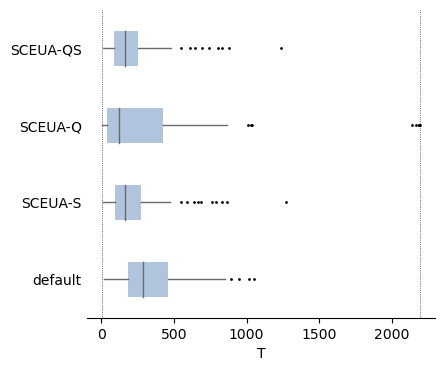

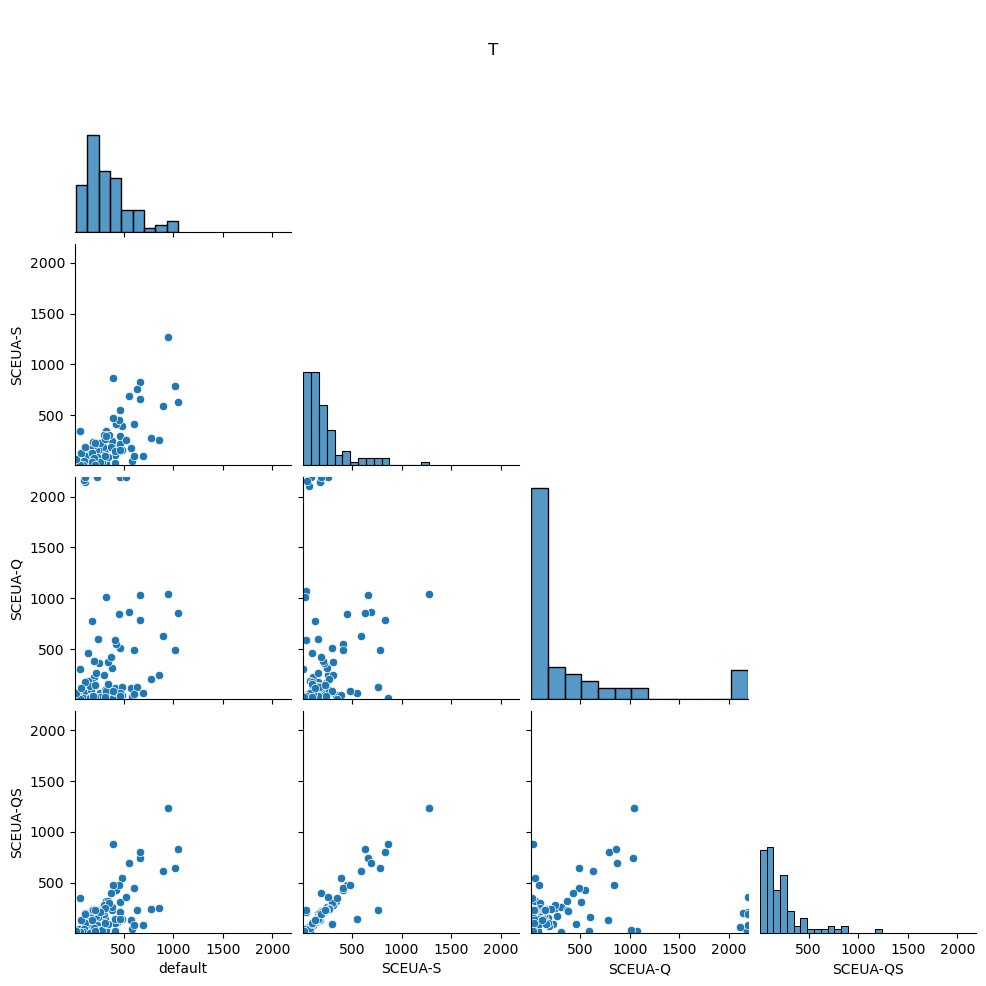

In [10]:
model = 'linear'
parameter_range = {'T': [7, 2190]}

pars_model = parameters[model][list(parameter_range)]

# boxplot comparing parameterizations across calibration runs
boxplot_parameters(pars_model, parameter_range, save=PATH_RESULTS / model / 'parameters_boxplot.jpg')

# pairplot comparing parameters
if len(pars_model) > 1:
    pairplot = sns.pairplot(
        data=pars_model.to_dataframe().reset_index(),
        vars=list(parameter_range),
        hue='run',
        # palette='magma',
        corner=True,
        dropna=True,
        plot_kws={'alpha': 0.666, 's': 10},
    );
    plt.savefig(PATH_RESULTS / model / 'parameters_pairplot.jpg', dpi=300, bbox_inches='tight')

# pairplot comparing runs for each parameter
for parname, da in pars_model.items():
    data = da.to_pandas().transpose()
    pairplot= sns.pairplot(data=data,
                           # diag_kind='hist',
                           # hue='MAIN_USE', 
                           corner=True);
    pmin, pmax = parameter_range[parname]
    pmin -= 2e-2
    pmax += 2e-2
    for ax in pairplot.axes.flatten():
        if ax is None:
            continue
        ax.set(xlim=(pmin, pmax),
               ylim=(pmin, pmax))
    pairplot.fig.suptitle(parname, y=.95);
    plt.savefig(PATH_RESULTS / model / f'parameter_{parname}_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Lisflood

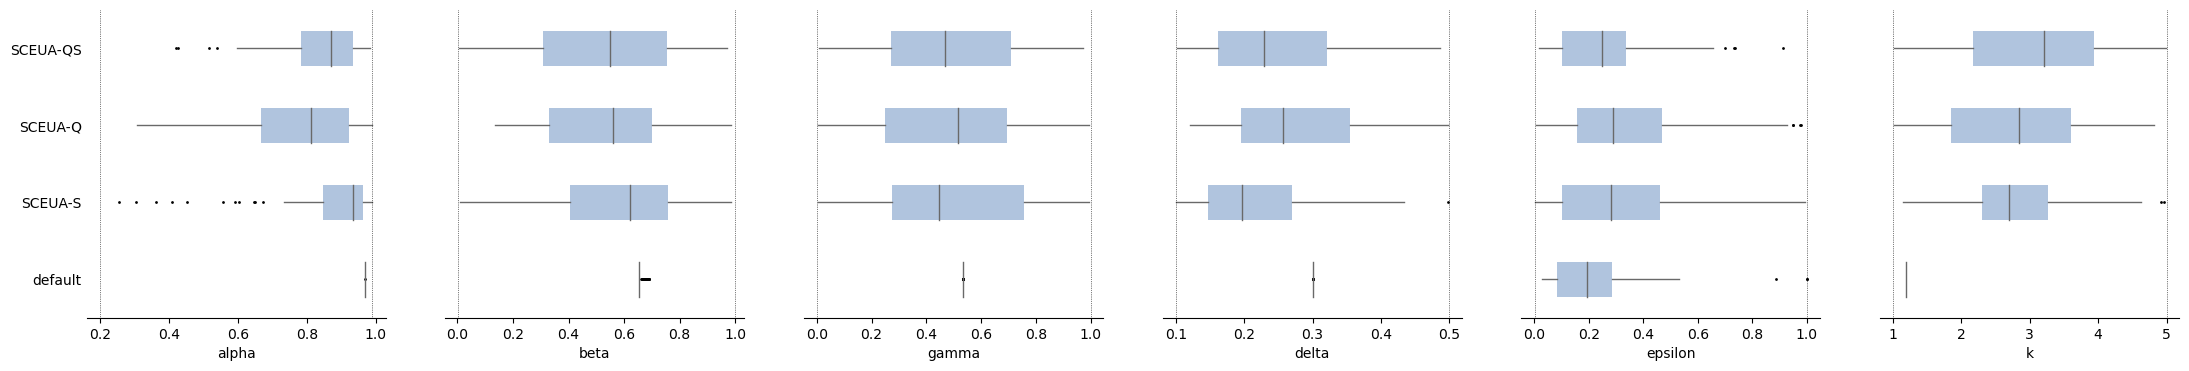

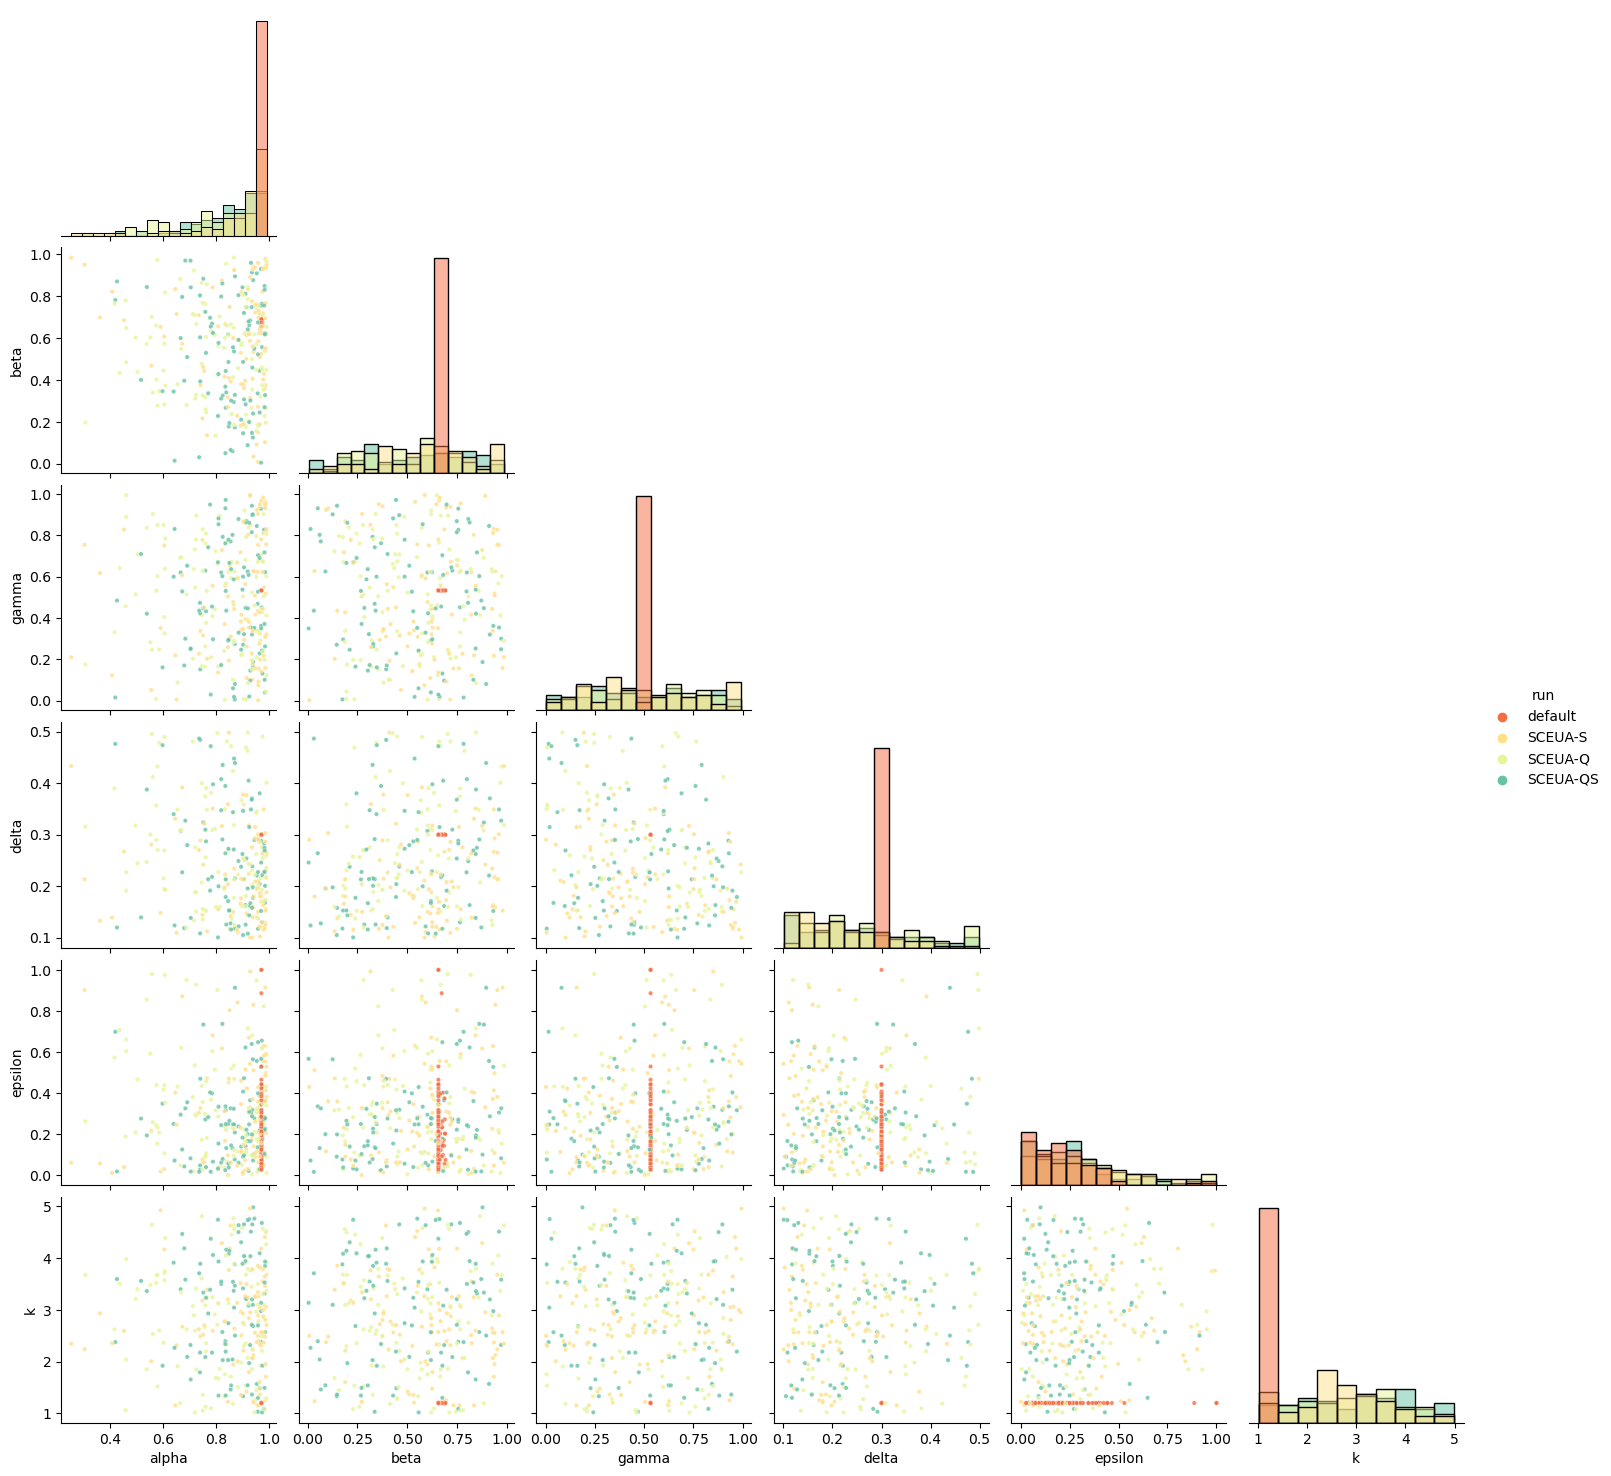

In [11]:
model = 'lisflood'

parameter_range = {
    'alpha': [0.20, 0.99],
    'beta': [0.001, 0.999],
    'gamma': [0.001, 0.999],
    'delta': [0.1, 0.5],
    'epsilon': [0.001, 0.999],
    'k': [1.0, 5.0]
}

pars_model = parameters[model]
pars_model = xr.Dataset({
    'alpha': pars_model['Vf'] / pars_model['Vtot'],
    'beta': (pars_model['Vn'] - pars_model['Vmin']) / (pars_model['Vf'] - pars_model['Vmin']),
    'gamma': (pars_model['Vn_adj'] - pars_model['Vn']) / (pars_model['Vf'] - pars_model['Vn']),
    'delta': pars_model['Qf'] / Q100,
    'epsilon': pars_model['Qn'] / pars_model['Qf'],
    'k': pars_model['k']
})

# boxplot comparing parameterizations across calibration runs
boxplot_parameters(pars_model, parameter_range, save=PATH_RESULTS / model / 'parameters_boxplot.jpg')

# pairplot comparing parameters
if len(pars_model) > 1:
    pairplot = sns.pairplot(
        data=pars_model.to_dataframe().reset_index(),
        vars=list(parameter_range),
        hue='run',
        palette='Spectral',
        diag_kind='hist',
        corner=True,
        dropna=True,
        plot_kws={'alpha': 0.8, 's': 10},
    );
    plt.savefig(PATH_RESULTS / model / 'parameters_pairplot.jpg', dpi=300, bbox_inches='tight')

# # pairplot comparing runs for each parameter
# for parname, da in pars_model.items():
#     data = da.to_pandas().transpose()
#     pairplot= sns.pairplot(data=data,
#                            # diag_kind='hist',
#                            # hue='MAIN_USE', 
#                            corner=True);
#     pmin, pmax = parameter_range[parname]
#     pmin -= 2e-2
#     pmax += 2e-2
#     for ax in pairplot.axes.flatten():
#         if ax is None:
#             continue
#         ax.set(xlim=(pmin, pmax),
#                ylim=(pmin, pmax))
#     pairplot.fig.suptitle(parname, y=.95);
#     plt.savefig(PATH_RESULTS / model / f'parameter_{parname}_pairplot.jpg', dpi=300, bbox_inches='tight')

In [ ]:
pars_model.median('ID').to_pandas()

#### Hanazaki

In [ ]:
ds = parameters['hanazaki']

ds

In [ ]:
ds.where((ds['Ve'] > ds['Vtot']).any('run'), drop=True)

In [ ]:
ds[['Qmin', 'Qn']].sel(ID=[7313]).to_dataframe()

In [ ]:
from lisfloodreservoirs.models import Lisflood

In [ ]:
res = Lisflood(Qf=347,
               Qmin=0.0,
               Qn=6.4,
               Vf=105879765,
               Vmin=11089100,
               Vn=83263414,
               Vn_adj=97339496,
               Vtot=110891000,
               k=1.158)

In [ ]:
res.plot_routine()

In [ ]:
ts = timeseries[42]
sim = res.simulate(ts.inflow, ts.storage.iloc[0], routine=1, limit_Q=True)

In [ ]:
res.get_params()

In [ ]:
res.scatter(sim, ts, norm=False,
            Vlims=[11089100, 83263414, 97339496, 105879765],
            Qlims=[0.0, 6.4, 6.4, 347])

In [ ]:
ts.inflow.mean() * 3600 * 24 * 1e-6

In [ ]:
(res.Vf - res.Vn_adj) * 1e-6

In [ ]:
ds[['Vtot', 'Vf']].sel(ID=1777).to_pandas()

In [13]:
pars_model['alpha'].where(pars_model['alpha'] < 0.2, drop=True).to_pandas()

ID,780,1777
run,,
default,0.139435,0.001041


In [28]:
pars_model['epsilon'].to_pandas().min(axis=1)

run
default     0.027104
SCEUA-S     0.001548
SCEUA-Q     0.003038
SCEUA-QS    0.003230
dtype: float64

<AxesSubplot:xlabel='date'>

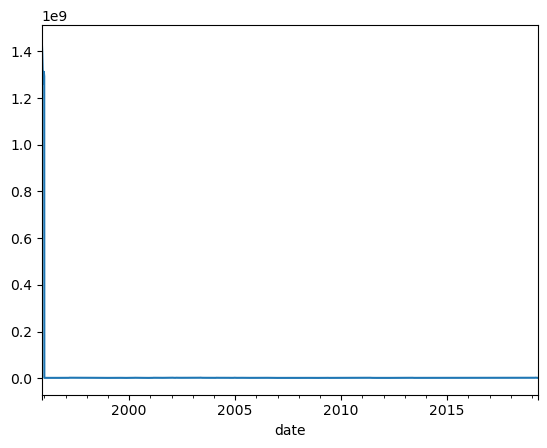

In [15]:
timeseries[1777].storage.plot()

In [16]:
attributes.loc[1777, 'CAP_MCM']

2580.4

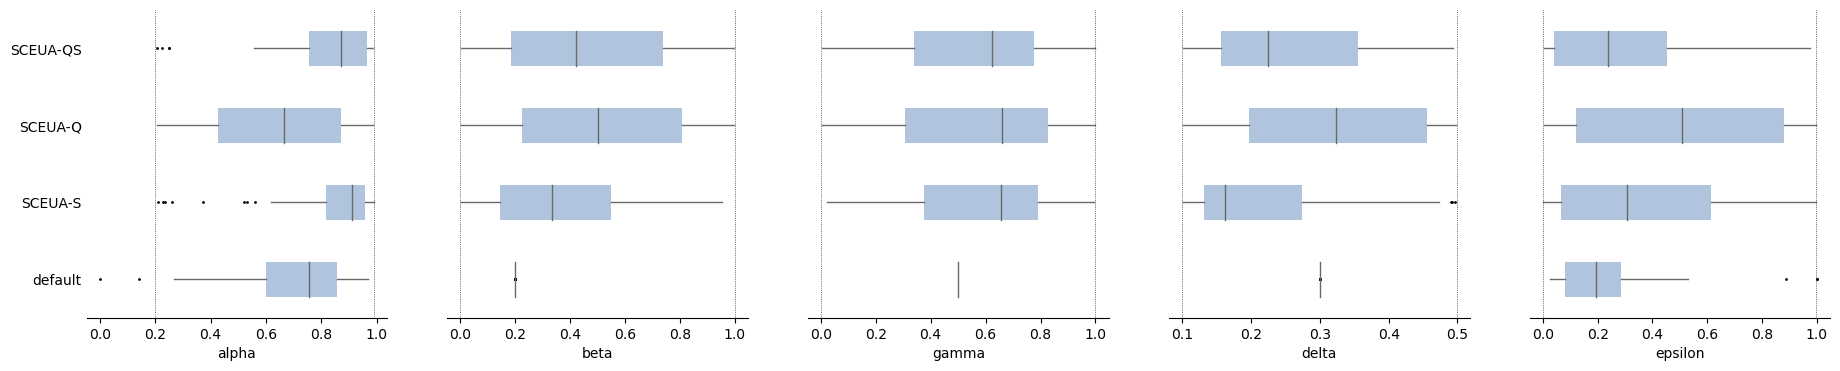

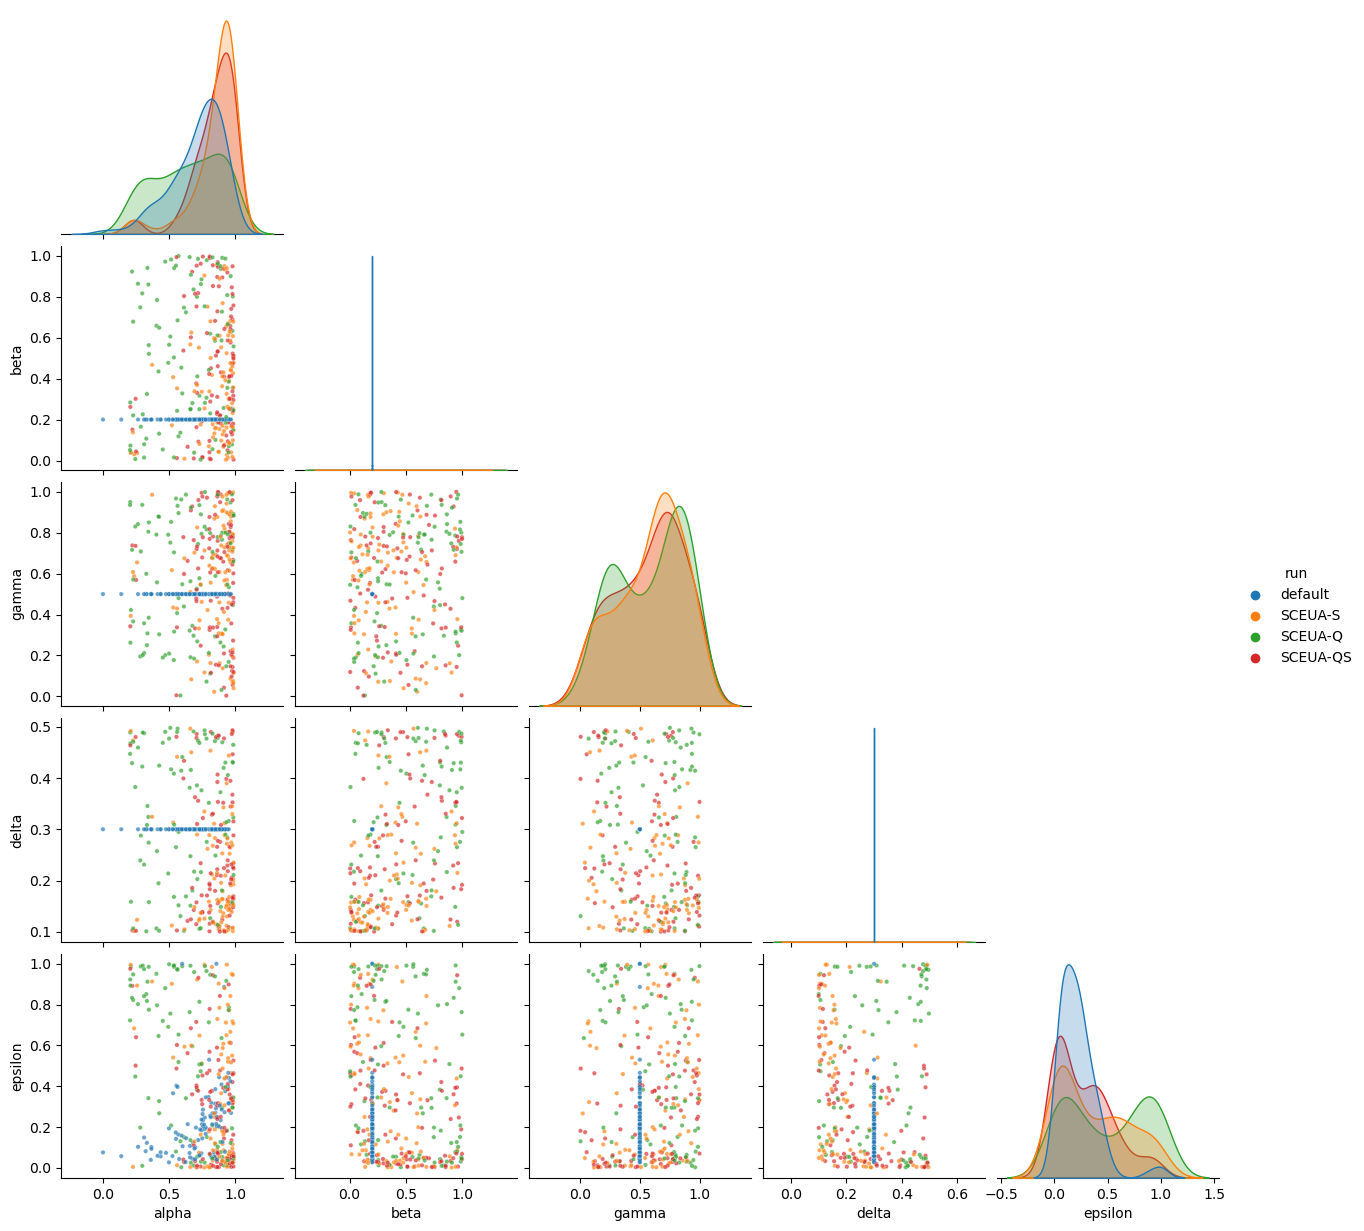

In [23]:
model = 'hanazaki'

parameter_range = {
    'alpha': [0.2, 0.99],
    'beta': [0.001, 0.999],    
    'gamma': [0.001, 0.999],
    'delta': [0.1, 0.5],
    'epsilon': [0.001, 0.999]
}

pars_model = parameters[model]
pars_model = xr.Dataset({
    'alpha': pars_model['Vf'] / pars_model['Vtot'],
    'beta': (pars_model['Vtot'] - pars_model['Ve']) / (pars_model['Vtot'] - pars_model['Vf']),
    'gamma': pars_model['Vmin'] / pars_model['Vf'],
    'delta': pars_model['Qf'] / Q100,
    'epsilon': pars_model['Qn'] / pars_model['Qf']
})

# boxplot comparing parameterizations across calibration runs
boxplot_parameters(pars_model, parameter_range, save=PATH_RESULTS / model / 'parameters_boxplot.jpg')

# pairplot comparing parameters
if len(pars_model) > 1:
    pairplot = sns.pairplot(
        data=pars_model.to_dataframe().reset_index(),
        vars=list(parameter_range),
        hue='run',
        # palette='magma',
        corner=True,
        dropna=True,
        plot_kws={'alpha': 0.666, 's': 10},
    );
    plt.savefig(PATH_RESULTS / model / 'parameters_pairplot.jpg', dpi=300, bbox_inches='tight')

# # pairplot comparing runs for each parameter
# for parname, da in pars_model.items():
#     data = da.to_pandas().transpose()
#     pairplot= sns.pairplot(data=data,
#                            # diag_kind='hist',
#                            # hue='MAIN_USE', 
#                            corner=True);
#     pmin, pmax = parameter_range[parname]
#     pmin -= 2e-2
#     pmax += 2e-2
#     for ax in pairplot.axes.flatten():
#         if ax is None:
#             continue
#         ax.set(xlim=(pmin, pmax),
#                ylim=(pmin, pmax))
#     pairplot.fig.suptitle(parname, y=.95);
#     plt.savefig(PATH_RESULTS / model / f'parameter_{parname}_pairplot.jpg', dpi=300, bbox_inches='tight')

#### mHM

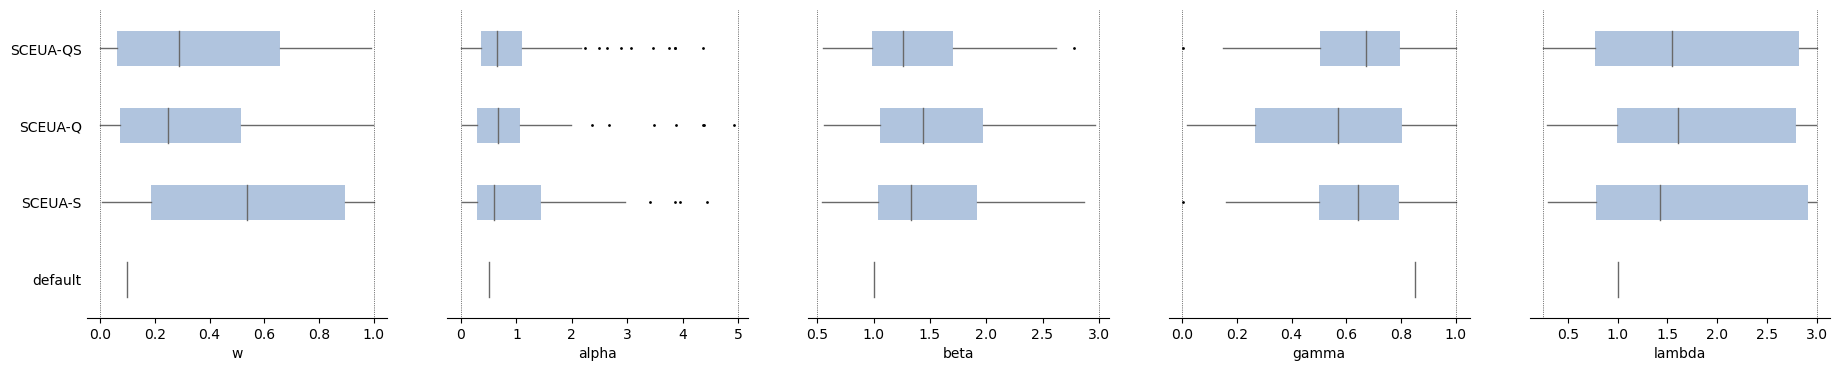

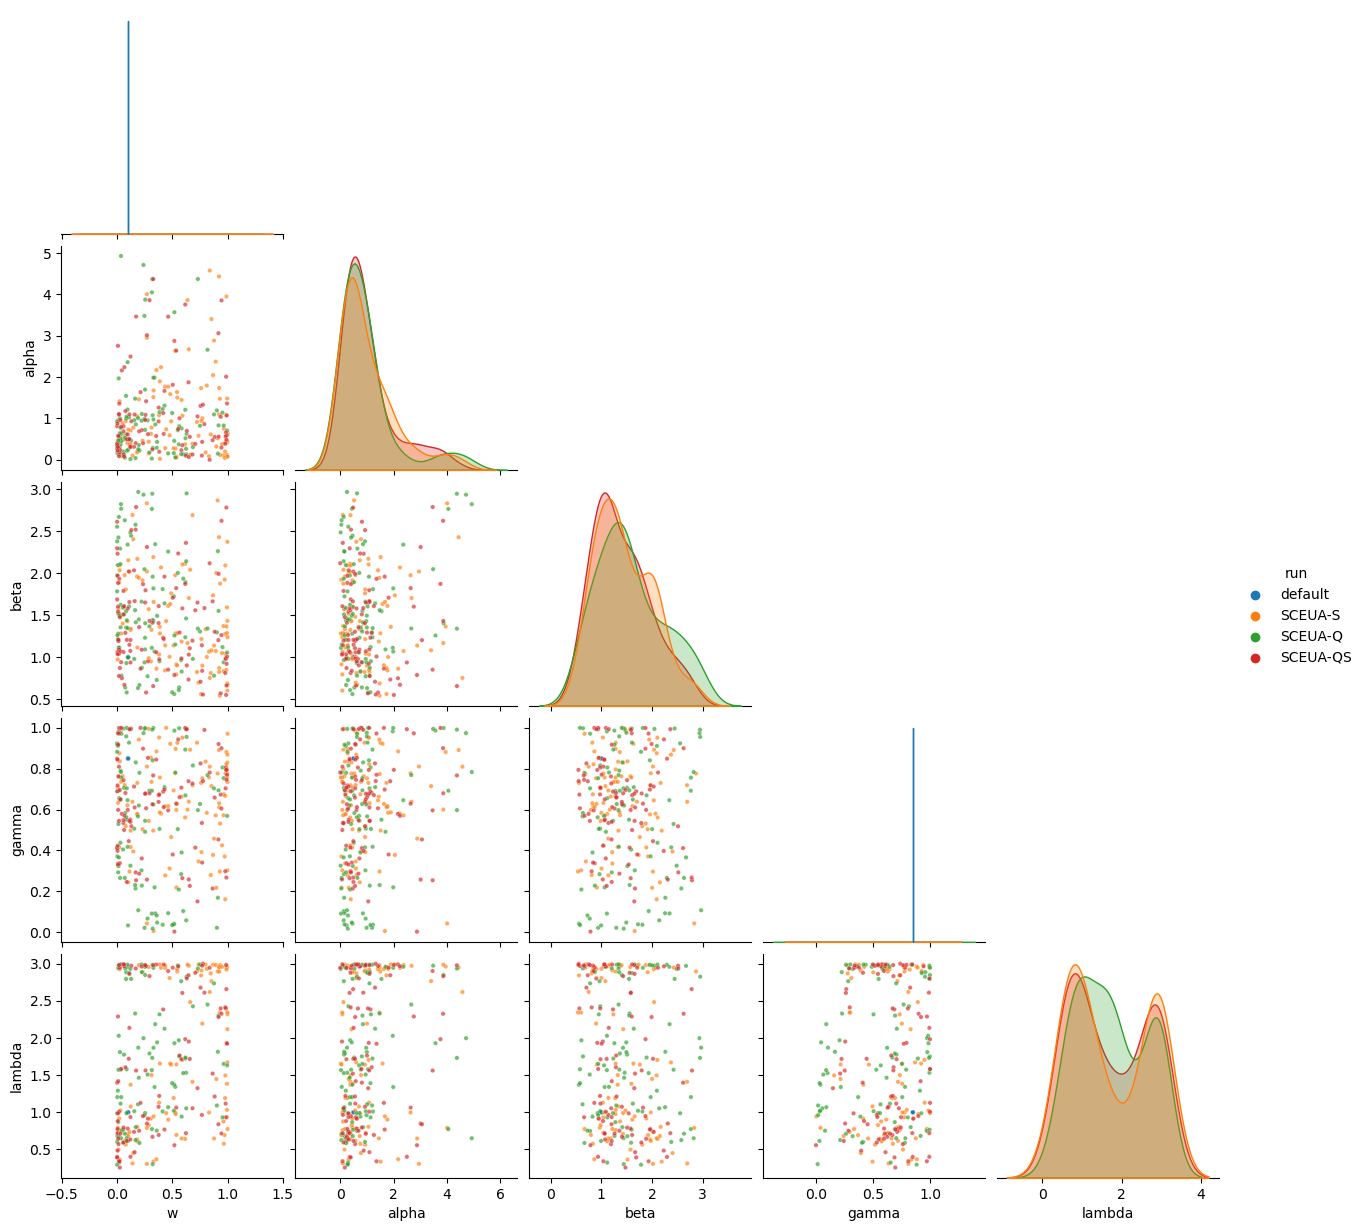

In [17]:
model = 'mhm'

parameter_range = {
    'w': [0.0, 1.0],
    'alpha': [0.0, 5.0],
    'beta': [0.5, 3.0],
    'gamma': [0.0, 1.0],
    'lambda': [0.25, 3.0]
}

pars_model = parameters[model][list(parameter_range)]

# boxplot comparing parameterizations across calibration runs
boxplot_parameters(pars_model, parameter_range, save=PATH_RESULTS / model / 'parameters_boxplot.jpg')

# pairplot comparing parameters
if len(pars_model) > 1:
    pairplot = sns.pairplot(
        data=pars_model.to_dataframe().reset_index(),
        vars=list(parameter_range),
        hue='run',
        # palette='magma',
        corner=True,
        dropna=True,
        plot_kws={'alpha': 0.666, 's': 10},
    );
    plt.savefig(PATH_RESULTS / model / 'parameters_pairplot.jpg', dpi=300, bbox_inches='tight')

# # pairplot comparing runs for each parameter
# for parname, da in pars_model.items():
#     data = da.to_pandas().transpose()
#     pairplot= sns.pairplot(data=data,
#                            # diag_kind='hist',
#                            # hue='MAIN_USE', 
#                            corner=True);
#     pmin, pmax = parameter_range[parname]
#     pmin -= 2e-2
#     pmax += 2e-2
#     for ax in pairplot.axes.flatten():
#         if ax is None:
#             continue
#         ax.set(xlim=(pmin, pmax),
#                ylim=(pmin, pmax))
#     pairplot.fig.suptitle(parname, y=.95);
#     plt.savefig(PATH_RESULTS / model / f'parameter_{parname}_pairplot.jpg', dpi=300, bbox_inches='tight')

In [ ]:
pars_model.median('ID').to_pandas()

## Correct parameter files

```Python
from lisfloodreservoirs.calibration import read_results
from lisfloodreservoirs.utils.timeseries import create_demand
from lisfloodreservoirs.models import get_model
import copy

for model in ['mhm']:
    for run in ['SCEUA-Q', 'SCEUA-S', 'SCEUA-QS']:
        # path results
        path = PATH_RESULTS / model / runs[run]

        for file in path.glob('*samples.csv'):
                    
            # reservoir ID and time series
            grand_id = int(file.stem.split('_')[0])
            ts = timeseries[grand_id]

            # storage attributes (m3)
            Vtot = ts.storage.max()
            Vmin = max(0, ts.storage.min())
            # flow attributes (m3/s)
            Qmin = max(0, ts.outflow.min())
            # model-independent reservoir attributes
            reservoir_attrs = {
                'Vmin': Vmin,
                'Vtot': Vtot,
                'Qmin': Qmin,
                }
            if model == 'hanazaki':
                # catchment area (m2)
                A = int(attributes.loc[grand_id, 'CATCH_SKM'] * 1e6)
                reservoir_attrs.update({'A': A})
                del reservoir_attrs['Qmin']
            elif model == 'mhm':
                # create a demand time series
                bias = ts.outflow.mean() / ts.inflow.mean()
                demand = create_demand(ts.outflow,
                                       water_stress=min(1, bias),
                                       window=28)

            # read calibration results
            iterations, attributes = read_results(file)

            # udpate reservoir attributes
            calibrated_attrs = copy.deepcopy(reservoir_attrs)
            if model == 'hanazaki':
                Vf = float(ts.storage.quantile(attributes['alpha']))
                Ve = Vtot - attributes['beta'] * (Vtot - Vf)
                Vmin = attributes['gamma'] * Vf
                Qn = attributes['delta'] * ts.inflow.mean()
                Qf = attributes['epsilon'] * return_period(ts.inflow, T=100)
                calibrated_attrs.update({
                    'Vf': Vf,
                    'Ve': Ve,
                    'Vmin': Vmin,
                    'Qn': Qn,
                    'Qf': Qf,
                    'A': A
                })
            elif model == 'mhm':
                calibrated_attrs.update(attributes)
                calibrated_attrs.update({
                    'avg_inflow': ts.inflow.mean(),
                    'avg_demand': demand.mean()
                })

            # declare reservoir
            res = get_model(model, **calibrated_attrs)
            
            # export calibrated attributes
            with open(path / f'{grand_id}_optimal_attributes.yml', 'w') as f:
                yaml.dump(res.get_params(), f)
```